<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/multi_modal/image_to_image_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image to Image Retrieval using CLIP embedding and image correlation reasoning using GPT-4o

In this notebook, we show how to build a Image to Image retrieval using LlamaIndex with GPT-4o and CLIP.

LlamaIndex Image to Image Retrieval 

- Images embedding index: [CLIP](https://github.com/openai/CLIP) embeddings from OpenAI for images


Framework: [LlamaIndex](https://github.com/run-llama/llama_index)

Steps:
1. Download texts, images, pdf raw files from Wikipedia pages

2. Build Multi-Modal index and vetor store for both texts and images

3. Retrieve relevant images given a image query using Multi-Modal Retriever

4. Using GPT4V for reasoning the correlations between the input image and retrieved images

In [ ]:
%pip install llama-index-llms-openai
%pip install llama-index-vector-stores-qdrant
%pip install wikipedia

In [ ]:
%pip install ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image

In [ ]:
import os

OPENAI_API_KEY = "sk-"
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

## Download images and texts from Wikipedia

In [ ]:
import wikipedia
import urllib.request
from pathlib import Path


image_path = Path("mixed_wiki")
image_uuid = 0
# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 10

wiki_titles = [
    "Vincent van Gogh",
    "San Francisco",
    "Batman",
    "iPhone",
    "Tesla Model S",
    "BTS band",
]

# create folder for images only
if not image_path.exists():
    Path.mkdir(image_path)


# Download images for wiki pages
# Assing UUID for each image
for title in wiki_titles:
    images_per_wiki = 0
    print(title)
    try:
        page_py = wikipedia.page(title)
        list_img_urls = page_py.images
        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1
                image_file_name = title + "_" + url.split("/")[-1]

                # img_path could be s3 path pointing to the raw image file in the future
                image_metadata_dict[image_uuid] = {
                    "filename": image_file_name,
                    "img_path": "./" + str(image_path / f"{image_uuid}.jpg"),
                }
                urllib.request.urlretrieve(
                    url, image_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                print(url)
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        continue

Vincent van Gogh
https://upload.wikimedia.org/wikipedia/commons/4/48/Cuesmes_JPG001.jpg
https://upload.wikimedia.org/wikipedia/commons/4/4d/De_zaaier_-_s0029V1962_-_Van_Gogh_Museum.jpg
https://upload.wikimedia.org/wikipedia/commons/0/09/Felix_Rey_portrait_%26_sketch.jpg
https://upload.wikimedia.org/wikipedia/commons/5/51/Graves_of_Vincent_and_Th%C3%A9odore_Van_Gogh.jpg
https://upload.wikimedia.org/wikipedia/commons/5/54/Jo_van_Gogh-Bonger%2C_by_Woodbury_and_Page-2.jpg
https://upload.wikimedia.org/wikipedia/commons/f/f2/Kee_Vos_met_zoon_Jan-cropped.jpg
https://upload.wikimedia.org/wikipedia/commons/9/9c/Landscape_with_Wheat_Sheaves_and_Rising_Moon_%28F735%29.jpg
https://upload.wikimedia.org/wikipedia/commons/f/f1/Le_Forum_R%C3%A9publicain_%28Arles%29_-_30_December_1888_-_Vincent_van_Gogh_ear_incident.jpg
https://upload.wikimedia.org/wikipedia/commons/f/f6/Paul_Gauguin_-_Vincent_van_Gogh_painting_sunflowers_-_Google_Art_Project.jpg
https://upload.wikimedia.org/wikipedia/commons/3/35/Red_

### Plot images from Wikipedia

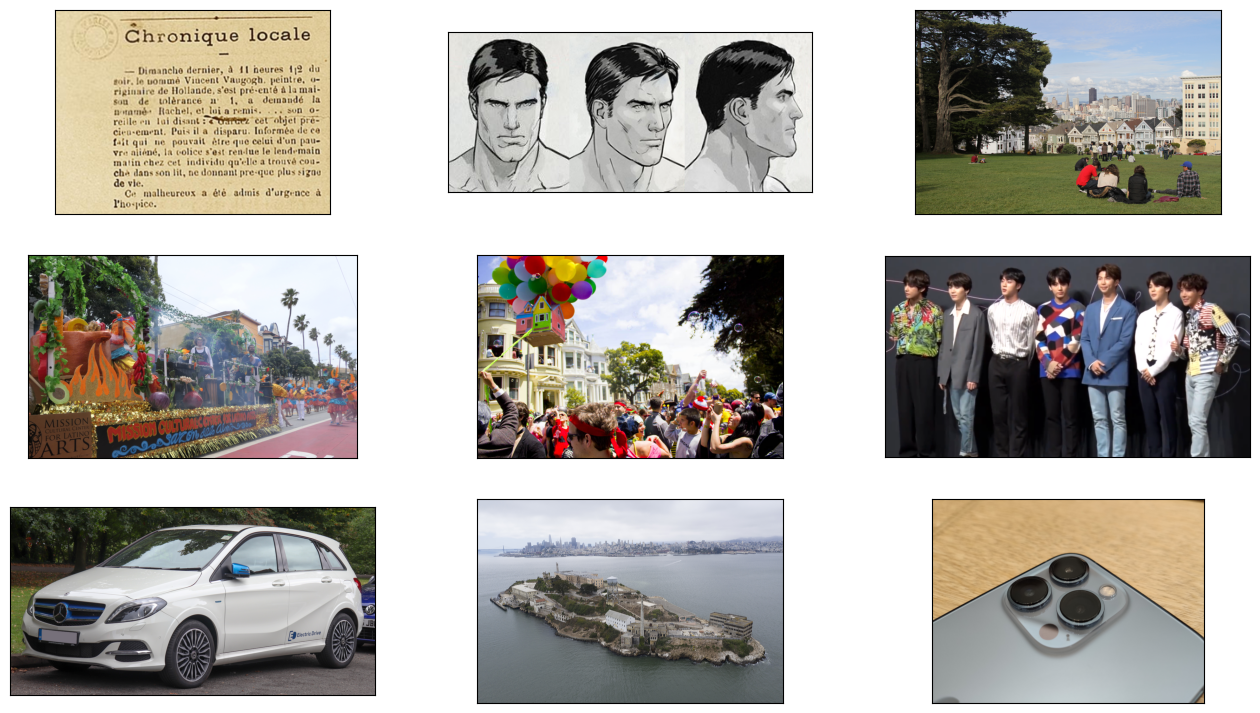

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("./mixed_wiki"):
    image_paths.append(str(os.path.join("./mixed_wiki", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths[::3]:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown == 9:
                break


plot_images(image_paths)

## Build Multi-Modal index and Vector Store to index both text and images from Wikipedia

In [ ]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import SimpleDirectoryReader, StorageContext

import qdrant_client
from llama_index.core import SimpleDirectoryReader


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_img_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
documents = SimpleDirectoryReader("./mixed_wiki/").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

## Plot input query image

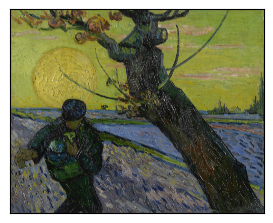

In [ ]:
input_image = "./mixed_wiki/2.jpg"
plot_images([input_image])

## Retrieve images from Multi-Modal Index given the image query

### 1. Image to Image Retrieval Results

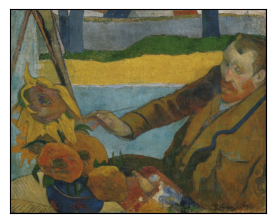

In [ ]:
# generate Text retrieval results
retriever_engine = index.as_retriever(image_similarity_top_k=4)
# retrieve more information from the GPT4V response
retrieval_results = retriever_engine.image_to_image_retrieve(
    "./mixed_wiki/2.jpg"
)
retrieved_images = []
for res in retrieval_results:
    retrieved_images.append(res.node.metadata["file_path"])

# Remove the first retrieved image as it is the input image
# since the input image will get the highest similarity score
plot_images(retrieved_images[1:])

### 2. GPT4V Reasoning Retrieved Images based on Input Image

In [ ]:
from pathlib import Path
from llama_index.llms.openai import OpenAI
from llama_index.core.llms import (
    ChatMessage,
    ImageBlock,
    TextBlock,
    MessageRole,
)


blocks = [
    TextBlock(
        text="Given the first image as the base image, what the other images correspond to?"
    ),
    ImageBlock(path=Path(input_image), image_mimetype="image/jpeg"),
]
for res_img in retrieved_images[1:]:
    blocks.append(ImageBlock(path=Path(res_img), image_mimetype="image/jpeg"))


openai_mm_llm = OpenAI(model="gpt-4o", max_new_tokens=1500)
msg = ChatMessage(role=MessageRole.USER, blocks=blocks)
response = openai_mm_llm.chat([msg])

In [ ]:
print(response)

assistant: The first image is "The Sower" by Vincent van Gogh. The other images correspond to:

1. Second image: "The Painter of Sunflowers" by Paul Gauguin, depicting van Gogh.
2. Third image: "Wheat Field with Cypresses" by Vincent van Gogh.
3. Fourth image: "The Red Vineyard" by Vincent van Gogh.


## Using Image Query Engine 

Inside Query Engine, there are few steps:

1. Retrieve relevant images based on input image

2. Compose the `image_qa_template`` by using the promt text

3. Sending top k retrieved images and image_qa_template for GPT4V to answer/synthesis

In [ ]:
from llama_index.llms.openai import OpenAI
from llama_index.core import PromptTemplate


qa_tmpl_str = (
    "Given the images provided, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)

qa_tmpl = PromptTemplate(qa_tmpl_str)


openai_mm_llm = OpenAI(model="gpt-4o", max_new_tokens=1500)

query_engine = index.as_query_engine(
    llm=openai_mm_llm, image_qa_template=qa_tmpl
)

query_str = "Tell me more about the relationship between those paintings. "
response = query_engine.image_query("./mixed_wiki/2.jpg", query_str)

In [ ]:
print(response)

The first image you've provided is of Vincent van Gogh's painting known as "The Sower." This work is emblematic of Van Gogh's interest in the cycles of nature and the life of the rural worker. Painted in 1888, "The Sower" features a large, yellow sun setting in the background, casting a warm glow over the scene, with a foreground that includes a sower going about his work. Van Gogh’s use of vivid colors and dynamic, almost swirling brushstrokes are characteristic of his famous post-impressionistic style.

The second image appears to be "The Olive Trees" by Vincent van Gogh. This painting was also created in 1889, and it showcases Van Gogh's expressive use of color and form. The scene depicts a grove of olive trees with rolling hills in the background and a swirling sky, which is highly reminiscent of the style he used in his most famous work, "The Starry Night." "The Olive Trees" series conveys the vitality and movement that Van Gogh saw in the landscape around him while he was staying